In [1]:
train_dir = 'data/dogs-vs-cats/train'
test_dir = 'data/dogs-vs-cats/test'

In [2]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(512, activation='relu'))
finetune_model.add(layers.Dense(1, activation='sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
modelpath = 'model/dogs-vs-cats_2.hdf5'
checkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbos=0, save_best_only=True)

In [8]:
history = finetune_model.fit(
    train_generator, epochs=30, validation_data=test_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/30
1000/1000 [==============================] - 578s 578ms/step - loss: 0.3448 - accuracy: 0.8468 - val_loss: 0.2378 - val_accuracy: 0.9004
Epoch 2/30
1000/1000 [==============================] - 578s 578ms/step - loss: 0.2905 - accuracy: 0.8717 - val_loss: 0.2264 - val_accuracy: 0.9100
Epoch 3/30
1000/1000 [==============================] - 572s 572ms/step - loss: 0.2761 - accuracy: 0.8777 - val_loss: 0.2416 - val_accuracy: 0.8922
Epoch 4/30
1000/1000 [==============================] - 582s 582ms/step - loss: 0.2640 - accuracy: 0.8860 - val_loss: 0.2204 - val_accuracy: 0.9056
Epoch 5/30
1000/1000 [==============================] - 1361s 1s/step - loss: 0.2584 - accuracy: 0.8885 - val_loss: 0.2067 - val_accuracy: 0.9132
Epoch 6/30
1000/1000 [==============================] - 1139s 1s/step - loss: 0.2459 - accuracy: 0.8924 - val_loss: 0.2086 - val_accuracy: 0.9082
Epoch 7/30
1000/1000 [==============================] - 1644s 2s/step - loss: 0.2408 - accuracy: 0.8951 - val_loss: 

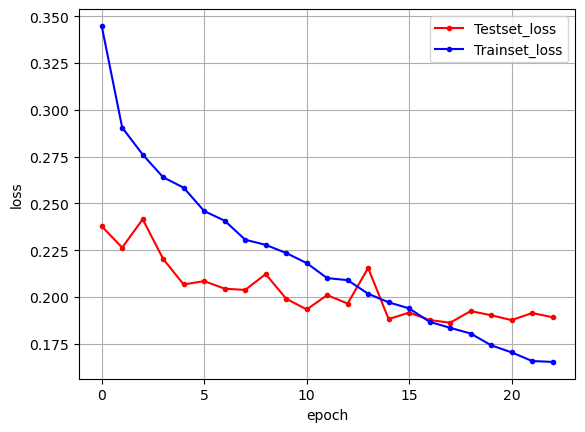

In [9]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()